In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
art_df_full = pd.read_csv("NewsSentimentScored.csv")

art_df_full["row_id"] = art_df_full.index + 1

art_df = art_df_full[['row_id', 'TEXT']].copy()

art_df['TEXT'] = art_df['TEXT'].str.replace("[^a-zA-Z#]", " ")

art_df['TEXT'] = art_df['TEXT'].str.casefold()

art_df = art_df.fillna('')

In [7]:
results_df = pd.DataFrame()
results_df['row_id'] = ['99999999999']
results_df['sentiment_type'] = pd.NA
results_df['sentiment_score'] = 0

In [8]:
sid = SentimentIntensityAnalyzer()
t_df = results_df

for index, row in art_df.iterrows():

    #print(index)

    scores = sid.polarity_scores(row[1])

    for key, value in scores.items():

        temp = [key,value,row[0]]

        results_df['row_id'] = row[0]
        results_df['sentiment_type'] = key
        results_df['sentiment_score'] = value

        t_df = pd.concat([t_df, results_df], ignore_index=True)

t_df_cleaned = t_df[t_df.row_id != '99999999999']

t_df_cleaned = t_df_cleaned.drop_duplicates()

t_df_cleaned = t_df[t_df.sentiment_type == 'compound']

In [9]:
article_scores_df = pd.merge(art_df_full, t_df_cleaned, on='row_id', how='inner')

article_scores_df = article_scores_df.drop('sentiment_type', axis=1)

bank_phrase_scores = pd.read_csv("ArticlePhrasesVADER.csv")

article_scores_df = pd.merge(article_scores_df, bank_phrase_scores, on='row_id', how='inner')

article_scores_df['YEAR'] = article_scores_df['DATE'].str.slice(0,4)

article_scores_df = article_scores_df.drop('row_id', axis=1)

article_scores_df = article_scores_df.dropna(subset=['TEXT'])

article_scores_df.to_csv("ArticleVADER.csv", encoding='utf-8', index=False)


In [4]:
article_scores_df = pd.read_csv("ArticleVADER.csv")

In [5]:
article_scores_df[["sentiment_score"]].describe()
#article_scores_df[["phrase_score"]].describe()

,sentiment_score
count,20914.000000
mean,0.354899
std,0.832344
min,-1.000000
25%,-0.714100
50%,0.931300
75%,0.991700
max,1.000000


<Axes: title={'center': 'Sentiment Score'}, xlabel='Period', ylabel='Mean Sentiment Score'>

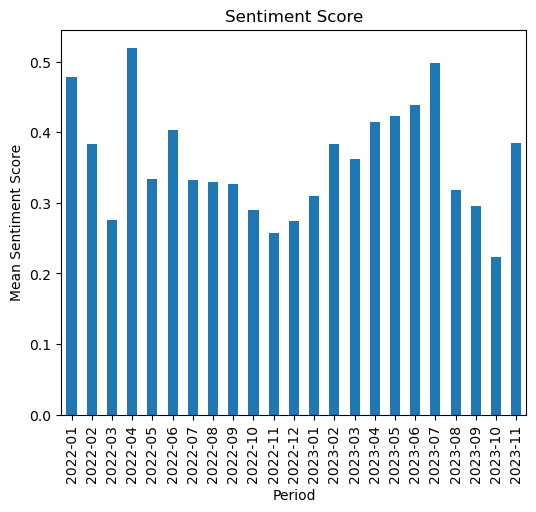

In [6]:
article_scores_df['YEAR_MONTH'] = article_scores_df['DATE'].str[6:] + "-" + article_scores_df['DATE'].str[3:5]
article_scores_df = article_scores_df[article_scores_df['YEAR_MONTH'] != '2007-07']


#generate mean of sentiment_score by period
dfg = article_scores_df.groupby(['YEAR_MONTH'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(6, 5))

<Axes: title={'center': 'Phrase Score'}, xlabel='Period', ylabel='Mean Phrase Score'>

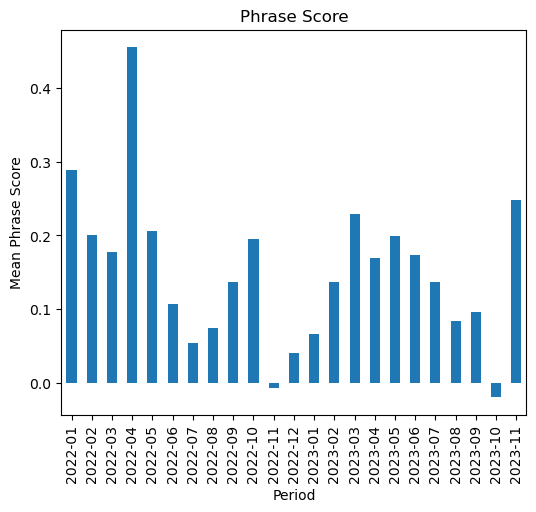

In [20]:
#generate mean of sentiment_score by period
dfg = article_scores_df.groupby(['YEAR_MONTH'])['phrase_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Phrase Score', ylabel='Mean Phrase Score',
         xlabel='Period', figsize=(6, 5))

<Axes: title={'center': 'Sentiment Score'}, xlabel='BANK', ylabel='Mean Sentiment Score'>

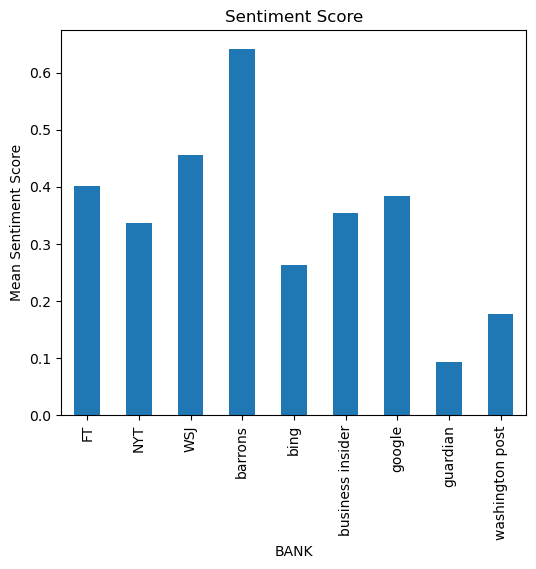

In [13]:
#generate mean of sentiment_score by period
dfg = article_scores_df.groupby(['OUTLET'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='BANK', figsize=(6, 5))

In [8]:
ArticleVADER = pd.read_csv("ArticleVADER.csv")

In [20]:

ArticleVADER['Diff_to_LLM'] = ArticleVADER['SENTIMENT'] -  ArticleVADER['phrase_score']

print(ArticleVADER['Diff_to_LLM'])

y = ArticleVADER['SENTIMENT'].to_list()
y_pred = ArticleVADER['phrase_score'].to_list()

cleaned_y = [x for x in y  if not np.isnan(x)]
cleaned_ypred = [x for x in y_pred  if not np.isnan(x)]

y_s = zip(y,y_pred)

y_val = []
y_pred_val = []

for elem in y_s:
    if not np.isnan(elem[0]) and not np.isnan(elem[0]):
        y_val.append(elem[0])
        y_pred_val.append(elem[1])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

mse = mean_squared_error(y_val, y_pred_val)
import numpy as np
from sklearn.metrics import accuracy_score


# Round actual and predicted values to the nearest integer
rounded_val = np.round(y_val)
rounded_pred = np.round(y_pred_val)

# Map rounded actual and predicted values to the nearest class among -1, 0, and 1
mapped_val = np.clip(rounded_val, -1, 1)
mapped_pred = np.clip(rounded_pred, -1, 1)

# Compute accuracy using the mapped actual and predicted values
accuracy = accuracy_score(mapped_val, mapped_pred)
print("Accuracy:", accuracy)

print(mse)

0        0.782607
1       -1.105681
2        1.730539
3       -0.974286
4       -0.943982
           ...   
20909   -0.817940
20910   -0.735067
20911    0.476660
20912   -0.811520
20913    0.895557
Name: Diff_to_LLM, Length: 20914, dtype: float64
Accuracy: 0.2860726518404168
0.5969731227520738


-0.2462062997886949


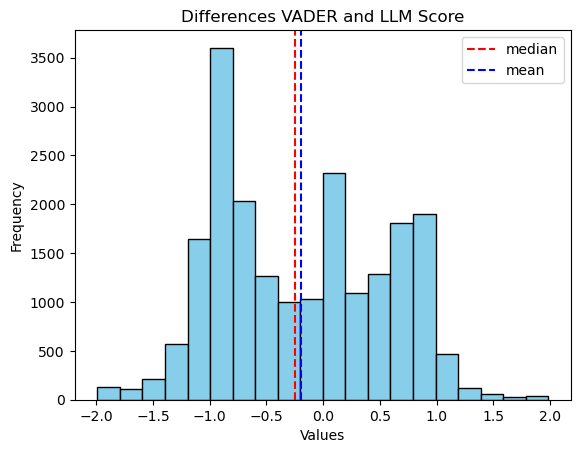

In [18]:
ArticleVADER['Diff_to_LLM'] = ArticleVADER['SENTIMENT'] -  ArticleVADER['phrase_score']

print(ArticleVADER['Diff_to_LLM'])

median = np.median(ArticleVADER['Diff_to_LLM'].dropna())
print(median)
mean = np.mean(ArticleVADER['Diff_to_LLM'].dropna())

plt.hist(ArticleVADER['Diff_to_LLM'] , bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.axvline( median, color='red', linestyle='dashed', linewidth=1.5, label = "median")
plt.axvline( mean, color='blue', linestyle='dashed', linewidth=1.5, label = "mean")
plt.title('Differences VADER and LLM Score')
plt.legend()
plt.show()